In [1]:
# Enable automatic import reloading
%load_ext autoreload
%autoreload 2

# Display outputs from all lines when they exist
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # "last"

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

import triadicsim

# Library/Import simulation utilities

## Graph generator

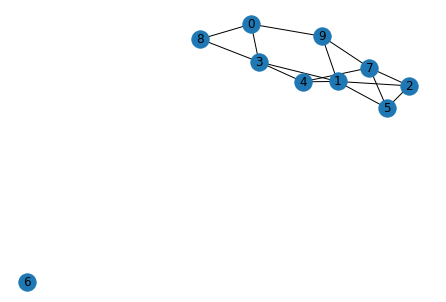

In [3]:
# Create a Gnp graph
G = triadicsim.graph(
    num_nodes=10, 
    graph_type='Gnp', 
    params={'p':0.3},
)
nx.draw(G, with_labels=True)

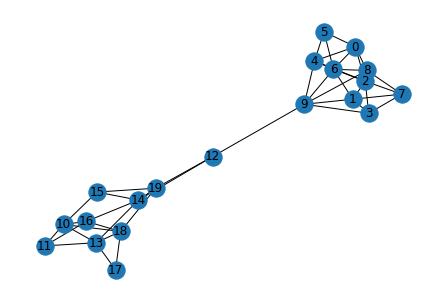

In [4]:
# Create a SBM graph
# NOTE community member node IDs are sequential
G = triadicsim.graph(
    num_nodes=20, 
    graph_type='stochastic',
    params={'within_p':0.5,'between_p':0.01},
)
nx.draw(G, with_labels=True)

## Triadic closures

In [5]:
# Get list of mutual connections between unconnected pairs of nodes
triadicsim.get_pair_mutuals(G)[:5]

[((2, 9), 4), ((13, 16), 4), ((0, 9), 3), ((1, 4), 3), ((1, 8), 3)]

[(2, 9), (13, 16), (0, 9), (1, 4), (1, 8)]

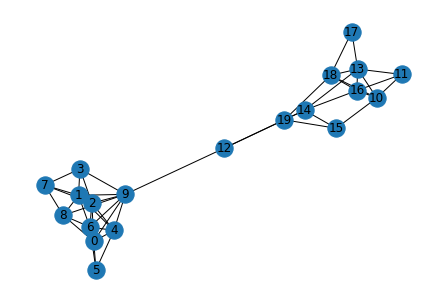

In [6]:
# Perform one round of edge creation
new_conns = triadicsim.closure_round(
    G, num_edges=5, method='max')
nx.draw(G, with_labels=True)
new_conns

## Threshold assignment

array([0.14240742, 0.3275869 , 0.        , 0.25388536, 0.23669222])

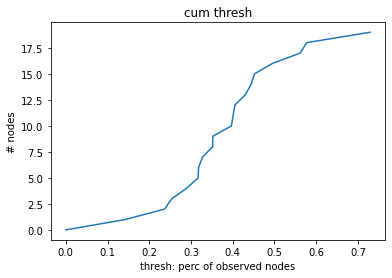

In [7]:
# Assign thresholds to all nodes
thresholds = triadicsim.create_thresholds(len(G))
thresholds[:5]

# Show cumulative distribution
thresholds_sorted = sorted(thresholds)
cum_thresh = [(thresholds_sorted[i], i) for i in range(len(thresholds_sorted))]
_ = plt.plot([x[0] for x in cum_thresh], [x[1] for x in cum_thresh])
_ = plt.title('cum thresh')
_ = plt.xlabel('thresh: perc of observed nodes')
_ = plt.ylabel('# nodes')
plt.show()

## Seed assignment

In [8]:
# Randomly select seeds out of a given set of node IDs
triadicsim.create_seedset(np.arange(10), 2)

array([5, 9])

## Graph cascading

In [9]:
# Run a population model cascade simulation
G = triadicsim.graph(
    num_nodes=20, 
    graph_type='Gnp', 
    params={'p':0.3},
    rng_seed=0,
)
thresholds = triadicsim.create_thresholds(len(G), rng_seed=0)
temp_seedset = triadicsim.create_seedset(len(G), 3, rng_seed=0)
G_log, node_log, edge_log, exit_status = triadicsim.simulate_cascade(
    G, 
    thresholds, 
    temp_seedset, 
    use_network=False,
    rng_seed=0
)
G_log
node_log
edge_log
exit_status

[{10, 12, 15},
 {9, 10, 12, 14, 15},
 {8, 9, 10, 12, 14, 15},
 {4, 8, 9, 10, 12, 14, 15, 16},
 {1, 4, 8, 9, 10, 12, 13, 14, 15, 16, 17},
 {0, 1, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18},
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19},
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}]

[set(), set(), set(), set(), set(), set(), set(), set()]

(True, True)

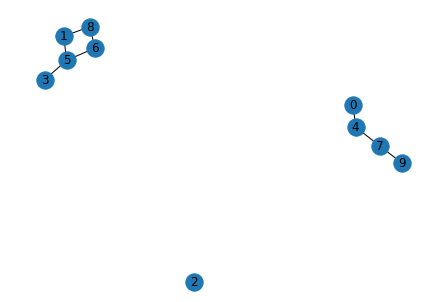

===


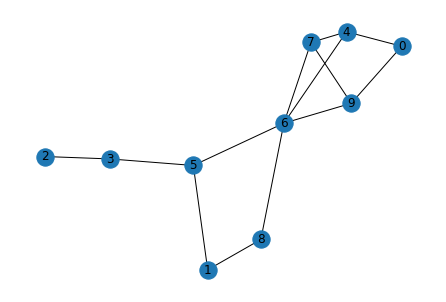

[{5, 6, 9},
 {1, 3, 5, 6, 8, 9},
 {1, 3, 5, 6, 7, 8, 9},
 {1, 2, 3, 4, 5, 6, 7, 8, 9},
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9},
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}]

[set(), {(7, 6)}, {(3, 2)}, {(9, 0)}, {(4, 6)}, {(6, 9)}]

(True, False)

In [10]:
# Run a triadic closure network model cascade simulation
G = triadicsim.graph(
    num_nodes=10, 
    graph_type='Gnp', 
    params={'p':0.3},
    rng_seed=0,
)
nx.draw(G, with_labels=True)
plt.show()

print('===')

thresholds = triadicsim.create_thresholds(len(G), rng_seed=0)
temp_seedset = triadicsim.create_seedset(len(G), 3, rng_seed=0)

G_log, node_log, edge_log, exit_status = triadicsim.simulate_cascade(
    G, 
    thresholds, 
    temp_seedset, 
    sticky_cascade=True,
    closure_type='random',
    max_rounds=20,
    rng_seed=0,
)
nx.draw(G_log[-1], with_labels=True)
plt.show()
node_log
edge_log
exit_status

# Examples of experiment code

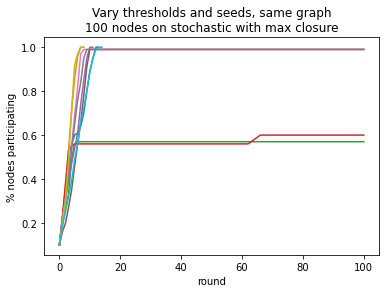

[1, 1, 0, 0, 1, 0, 0, 0, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[12, 7, 6, 66, 10, 10, 8, 9, 7, 13]


In [11]:
num_experiments = 10
graph_type = 'stochastic'
num_nodes = 100
num_seeds = 10
closure_method = "max"
max_rounds = 100

# Same graph, varying thresholds, varying seeds
rounds_filled = []
rounds_frozen = []
max_size_round = []
for i in range(num_experiments):
    # Initialize simulation inputs
    G = triadicsim.graph(
        num_nodes=num_nodes, 
        graph_type=graph_type, 
        rng_seed=0,
    )
    thresholds = triadicsim.create_thresholds(num_nodes)
    seedset = triadicsim.create_seedset(num_nodes, num_seeds)
    # Run simulation
    G_log, node_log, edge_log, exit_status = triadicsim.simulate_cascade(
        G, thresholds, seedset,
        use_network=True, sticky_cascade=True,
        closure_type=closure_method, closure_rate=1,
        max_rounds=max_rounds
    )
    # Compute history of infection rates
    num_reached_nodes = [len(s) for s in node_log]
    rounds_filled.append(1 if exit_status[0] else 0)
    rounds_frozen.append(1 if exit_status[1] else 0)
    max_size_round.append([
        i for i in range(len(num_reached_nodes)) 
        if num_reached_nodes[i]==max(num_reached_nodes)
    ][0])
    # Plot the output
    _ = plt.plot([x/num_nodes for x in num_reached_nodes])
_ = plt.xlabel('round')
_ = plt.ylabel('% nodes participating')
_ = plt.title(
    'Vary thresholds and seeds, same graph\n'
    + f'{num_nodes} nodes on {graph_type} with {closure_method} closure'
)
plt.show()

print(rounds_filled)
print(rounds_frozen)
print(max_size_round)

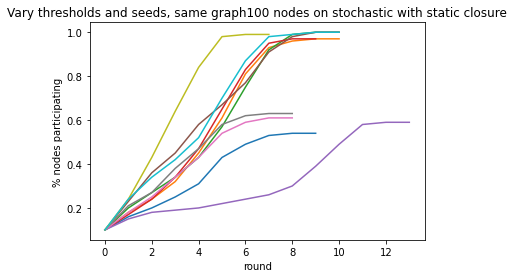

[0, 0, 1, 0, 0, 1, 0, 0, 0, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[8, 9, 9, 8, 12, 9, 7, 7, 6, 9]


In [12]:
num_experiments = 10
graph_type = 'stochastic'
num_nodes = 100
num_seeds = 10
closure_method = "static"
max_rounds = 100

# Same graph, varying thresholds, varying seeds
rounds_filled = []
rounds_frozen = []
max_size_round = []
for i in range(num_experiments):
    # Initialize simulation inputs
    G = triadicsim.graph(
        num_nodes=num_nodes, 
        graph_type=graph_type, 
        rng_seed=0,
    )
    thresholds = triadicsim.create_thresholds(num_nodes)
    seedset = triadicsim.create_seedset(num_nodes, num_seeds)
    # Run simulation
    G_log, node_log, edge_log, exit_status = triadicsim.simulate_cascade(
        G, thresholds, seedset,
        use_network=True, sticky_cascade=True,
        closure_type=closure_method, closure_rate=1,
        max_rounds=max_rounds
    )
    # Compute history of infection rates
    num_reached_nodes = [len(s) for s in node_log]
    rounds_filled.append(1 if exit_status[0] else 0)
    rounds_frozen.append(1 if exit_status[1] else 0)
    max_size_round.append([
        i for i in range(len(num_reached_nodes)) 
        if num_reached_nodes[i]==max(num_reached_nodes)
    ][0])
    # Plot the output
    _ = plt.plot([x/num_nodes for x in num_reached_nodes])
_ = plt.xlabel('round')
_ = plt.ylabel('% nodes participating')
_ = plt.title(
    'Vary thresholds and seeds, same graph'
    + f'{num_nodes} nodes on {graph_type} with {closure_method} closure'
)
plt.show()

print(rounds_filled)
print(rounds_frozen)
print(max_size_round)

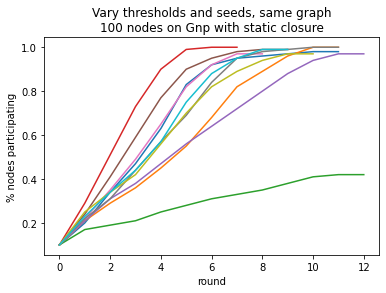

[0, 1, 0, 1, 0, 0, 0, 1, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[10, 10, 11, 6, 11, 8, 7, 10, 9, 8]


In [13]:
# Generalized, super-hyperparameter-collection version

num_experiments = 10
# Graph hyperparameters
graph_type = ['Gnp', 'stochastic'][0]
num_nodes = 100
graph_params = {
    'Gnp':{'p':0.1}, 
    'stochastic':{'within_p':0.5,'between_p':0.01}
}[graph_type]
# Threshold hyperparameters
threshold_mean = 0.4
threshold_var = 0.25
# Seed selection hyperparameters
seed_candidates = np.arange(num_nodes)
num_seeds = 10
# Simulation hyperparameters
use_network = True
sticky_cascade = True
closure_method = [
    'max', 
    'squared_weighted_random', 'weighted_random', 'random', 
    'static'
][4] if use_network else 'population_irrelevant'
closure_rate = 1
max_rounds = 100

# Same graph, varying thresholds, varying seeds
rounds_filled = []
rounds_frozen = []
max_size_round = []
for i in range(num_experiments):
    # Initialize simulation inputs
    G = triadicsim.graph(
        num_nodes=num_nodes, 
        graph_type=graph_type, 
        rng_seed=0,
    )
    thresholds = triadicsim.create_thresholds(
        num_nodes, mean=threshold_mean, var=threshold_var,
        rng_seed=None,
    )
    seedset = triadicsim.create_seedset(
        seed_candidates, num_seeds,
        rng_seed=None,
    )
    # Run simulation
    G_log, node_log, edge_log, exit_status = triadicsim.simulate_cascade(
        G, thresholds, seedset,
        use_network=use_network, sticky_cascade=sticky_cascade,
        closure_type=closure_method, closure_rate=closure_rate,
        max_rounds=max_rounds,
        rng_seed=None,
    )
    # Compute history of infection rates
    num_reached_nodes = [len(s) for s in node_log]
    rounds_filled.append(1 if exit_status[0] else 0)
    rounds_frozen.append(1 if exit_status[1] else 0)
    max_size_round.append([
        i for i in range(len(num_reached_nodes)) 
        if num_reached_nodes[i]==max(num_reached_nodes)
    ][0])
    # Plot the output
    _ = plt.plot([x/num_nodes for x in num_reached_nodes])
_ = plt.xlabel('round')
_ = plt.ylabel('% nodes participating')
_ = plt.title(
    'Vary thresholds and seeds, same graph\n'
    + f'{num_nodes} nodes on {graph_type} with {closure_method} closure'
)
plt.show()

print(rounds_filled)
print(rounds_frozen)
print(max_size_round)